# [2023-11-14] Cleaned-up visualizations

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from pathlib import Path

import pandas as pd
import numpy as onp
from scipy.ndimage import gaussian_filter1d
from functools import partial
from tqdm.auto import tqdm

from umap import UMAP

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from matplotlib.gridspec import GridSpec

# Setup matplotlib figure styles
plt.style.use('dark_background')
mpl.rcParams['font.size'] = 12

# For animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
mpl.rcParams['animation.ffmpeg_path'] = '/bin/ffmpeg'

# For gifs
import imageio.v3 as iio
import pygifsicle

from dtd.utils import download_wnb_params
from kf_viz import (set_syllable_cluster_ticks, SYLLABLE_PERM_DICT,
                    make_tod_series, draw_circadian_bases,
                    LIFESPAN_CMAP, make_lifespan_colobar, multicolored_lineplot)

In [27]:
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

# List run_ids to compare in this notebook
run_ids = [
    'ig6dh2fo',     # `warm-sweep-116`, seed = 1698740237
    # '46grddu7',     # `eternal-sweep-28`, seed = 1698499854 .. parameters not yet updated
    ]

# (Down)load fitted run parameters, retrievable by run_id code
run_params = {
    run_id: download_wnb_params(wnb_entity, wnb_project, run_id)
    for run_id in run_ids
}

print(f'{len(run_params.keys())} runs loaded, with keys \n', run_params[run_ids[0]].keys())

# Load age and name labels, these were re-obtained from the original data
with onp.load('age_name_labels.npz', 'r') as f:
    ages = f['ages']
    names = f['names']

unique_names, i_split = onp.unique(names, return_index=True)
ages_by_fish = onp.split(ages, i_split[1:])
assert len(ages_by_fish) == len(unique_names)
print(f'{len(ages_by_fish)} fish')

1 runs loaded, with keys 
 dict_keys(['G', 'F1', 'F2', 'F3', 'seed', 'avg_train_lps', 'avg_test_ll', 'avg_baseline_test_ll', 'avg_saturated_test_ll', 'avg_lofo_test_ll_1', 'avg_lofo_test_ll_2', 'avg_lofo_test_ll_3', 'run_id'])
82 fish


In [115]:
primary_run_id = 'ig6dh2fo'
F1 = run_params[primary_run_id]['F1']
F2 = run_params[primary_run_id]['F2']
F3 = run_params[primary_run_id]['F3']
G = run_params[primary_run_id]['G']

# This fish has a very nice median age of 282 days. He's our fave celeb
primary_fish_name = 'fish10_137_cohort5'
primary_selected_id = int(onp.nonzero(unique_names==fish_name)[0])

# Circadian bases

Text(0.05, 0.5, 'circadian bases')

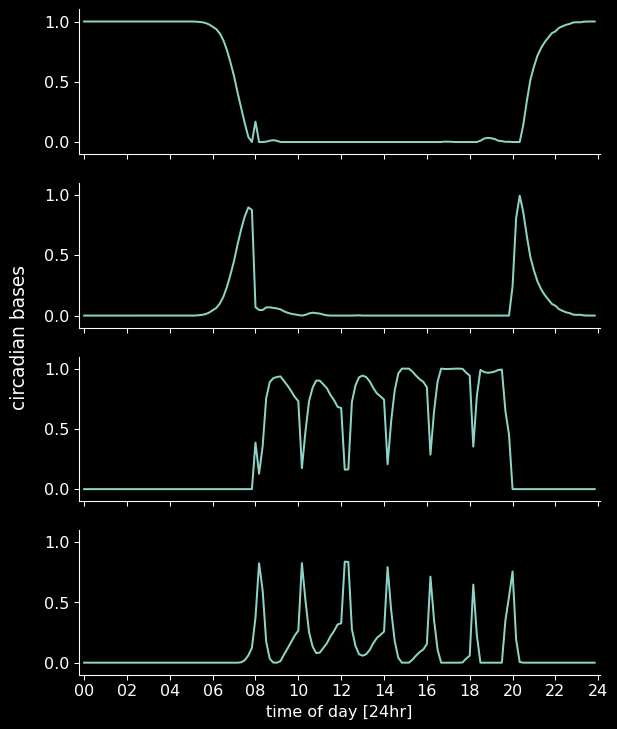

In [29]:
D2, K2 = F2.shape

ref_ll = run_params[primary_run_id]['avg_baseline_test_ll']
lofo_ll = run_params[primary_run_id]['avg_lofo_test_ll_2']
frac_diff = (ref_ll - lofo_ll) / ref_ll 

# ------

fig, axs = plt.subplots(nrows=K2, ncols=1, sharex='all', sharey='all',
                        figsize=(7,9), dpi=96)

# Don't sort by ll explained -- I have a suspicion that it is influenced by the
# overall norm of the basis
draw_circadian_bases(F2[:,[0,2,1,3]], tod_freq='2H', autosort=False, axs=axs);

# # Indicate ll explained
# for ax, frac in zip(axs, frac_diff):
#     ax.text(1.02, 0, f'{frac:.2f}', transform=ax.transAxes, ha='left',
#             fontsize='x-small', va='center',
#             bbox=dict(facecolor='white', alpha=0.1, pad=2))

# y-axis: show tick labels and label
for ax in axs: ax.tick_params(labelleft=True)
plt.text(0.05, 0.5, 'circadian bases', transform=fig.transFigure,
         rotation=90, ha='right', va='center', fontsize=14)

# Age factor visualization

In [30]:
def split_array_by_fish(arr, ages, axis: int=0) -> onp.ndarray:
    """Split array by fish.
        
        Parameters
            arr: jax.Array, shape (..., D,...)
            ages: list, length N, cumulative D entries
            axis: int, indicating position of length-D axis in `arr`

        Returns
            arr_by_fish: list[jax.Array], length N
        """

    i_split = onp.cumsum([len(ages_i) for ages_i in ages])
    assert i_split[-1] == arr.shape[axis], \
        f'Expected cumulative # of elements in ages to match age mode of array, but got {i_split[-1]} and {arr.shape[axis]}'
    
    return onp.split(arr, i_split[:-1], axis=axis)

## viz

In [31]:
def plot_age_factor_by_fish_sep(gs, age_component, ages_by_fish, lw=1, color_by='lifespan'):
    """Plot age factors, with each subject seperated onto its own plot."""
    gs_fctr = gs.subgridspec(nrows=len(ages_by_fish), ncols=1, hspace=0.1)

    age_component_by_fish = split_array_by_fish(age_component, ages_by_fish)

    # Share axes across all fish
    xmin = onp.min(list(map(lambda ages: ages[0], ages_by_fish)))
    xmax = onp.max(list(map(lambda ages: ages[-1], ages_by_fish)))
    ymax = onp.minimum(2*onp.quantile(age_component, 0.99), 1)
    # y_max = 1

    # Sort subjects from shortest-living to longest living
    axs = []
    i_sort = onp.argsort(list(map(lambda ages: ages[-1], ages_by_fish)))
    for i_ax, i in enumerate(i_sort):
        _ages = ages_by_fish[i]
        _component = age_component_by_fish[i]

        ax = plt.gcf().add_subplot(gs_fctr[i_ax,:])

        if color_by == 'rel_age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(0, 1)
            ax.margins(x=1.1)
        elif color_by == 'age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(xmin, xmax)
        elif color_by == 'lifespan':   # color by lifespan
            c = LIFESPAN_CMAP(AGE_NORM(_ages[-1]))
            ax.plot(_ages, _component, color=c, lw=lw)
            ax.set_xlim(xmin, xmax)
        else:
            raise ValueError("Expected `color_by`=\{'rel_age', 'age', 'lifespan'\}," + f" but got '{color_by}'.")
            
        ax.set_ylim(0, ymax)

        # Only label ticks on last row; deemphasize axes of intermediate rows
        if i_ax < len(ages_by_fish) - 1:
            ax.tick_params(length=1, labelleft=False, labelbottom=False)
            ax.spines['bottom'].set_color('0.4')
        else:
            ax.tick_params(length=1, labelleft=False, labelsize='x-small' )
        
        sns.despine(ax=ax)
        axs.append(ax)
    return axs

def plot_age_factor_by_fish_overlaid(gs, age_component, ages_by_fish, lw=1, color_by='lifespan', alpha=1, sigma=0):
    """Plot age factors, with each subject seperated onto its own plot."""

    age_component_by_fish = split_array_by_fish(age_component, ages_by_fish)

    # Share axes across all fish
    xmin = onp.min(list(map(lambda ages: ages[0], ages_by_fish)))
    xmax = onp.max(list(map(lambda ages: ages[-1], ages_by_fish)))
    ymax = onp.minimum(2*onp.quantile(age_component, 0.99), 1)
    # y_max = 1

    # Sort subjects from shortest-living to longest living
    ax = plt.gcf().add_subplot(gs)
    i_sort = onp.argsort(list(map(lambda ages: ages[-1], ages_by_fish)))
    for i_ax, i in enumerate(i_sort):
        _ages = ages_by_fish[i]
        
        _component = age_component_by_fish[i]
        
        if sigma > 0:
            _component = gaussian_filter1d(age_component_by_fish[i], sigma, axis=0)
        

        if color_by == 'rel_age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM, alpha=alpha)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(0, 1)
            ax.margins(x=1.1)
        elif color_by == 'age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM, alpha=alpha)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(xmin, xmax)
        elif color_by == 'lifespan':   # color by lifespan
            c = LIFESPAN_CMAP(AGE_NORM(_ages[-1]))
            ax.plot(_ages, _component, color=c, lw=lw, alpha=alpha)
            ax.set_xlim(xmin, xmax)
        else:
            raise ValueError("Expected `color_by`=\{'rel_age', 'age', 'lifespan'\}," + f" but got '{color_by}'.")
        
    ax.set_ylim(0, ymax)

    # Only label ticks on last row; deemphasize axes of intermediate rows
    ax.tick_params(length=1, labelleft=False, labelbottom=False)
    ax.spines['bottom'].set_color('0.4')
        
    sns.despine(ax=ax)
    return ax

def plot_normd_age_factor_and_mat(gs, core, age_fctr, tod_fctr, syllable_fctr, a, ages):
    # Plot age factor
    # ax_fctrs = plot_age_factor_by_fish_sep(gs[0,:], age_fctr[:,a], ages, lw=0.5, color_by='age')
    # ax_fctrs[-1].set_xlabel('age [days]', fontsize='x-small')
    # ax_fctrs[0].set_title(f'a = {a}')
    
    ax_fctrs = plot_age_factor_by_fish_overlaid(gs[0,:], age_fctr[:,a], ages, lw=0.5, color_by='age', alpha=0.4, sigma=1.5)
    ax_fctrs.set_xlabel('age [days]', fontsize='x-small')
    ax_fctrs.set_title(f'a = {a}')

    # Plot the circadian-topic basis matrix that it interacts with
    ax_elem = plt.gcf().add_subplot(gs[1,1])
    mat_a = onp.einsum('tb,bc,cv->tv', tod_fctr, core[a], syllable_fctr)
    
    im = ax_elem.imshow(mat_a.T, interpolation='none', aspect='auto',
                        cmap='mako', norm=mplc.LogNorm(vmin=1e-2, vmax=1))

    t_dts = make_tod_series('4H')
    t_locs = onp.concatenate([onp.linspace(0, len(tod_fctr), num=len(t_dts), endpoint=False), [len(tod_fctr)]])
    t_labels = list(map(lambda dt: dt.strftime('%H'), t_dts)) + ['24']
    
    ax_elem.set_xticks(t_locs)
    ax_elem.set_xticklabels(t_labels, fontsize='xx-small')

    ax_elem.set_xlabel('time-of-day [hr]', fontsize='x-small')
    
    ax_elem.grid(visible=False, axis='both')
    return (ax_fctrs, ax_elem), im

## Fit umap to all components

In [237]:
# Use all components! Since they're all equally important!
age_fctr_components = F1

# n_neighbors = int(len(age_fctr_components) * 0.1) / 2
n_neighbors = 72
min_dist = 0.25
n_umap_components = 3
metric = 'euclidean'

fit = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_umap_components,
        metric=metric,
        random_state=23,
    )
umap_embedding = fit.fit_transform(age_fctr_components)
print('Fitted!')

Fitted!


In [238]:
from sklearn.decomposition import PCA

# Let's flip the embeddings so that life trajectories align with our American
# semantic associations of left -> right, down -> up
_umap_embedding = onp.copy(umap_embedding)

# _umap_embedding = PCA(n_components=2).fit_transform(_umap_embedding)
# Center about origin, flip x
_umap_embedding -= _umap_embedding.mean(axis=0)
_umap_embedding[:,0] = -umap_embedding[:,0]
# _umap_embedding[:,1] = -umap_embedding[:,1]

# Recenter about origin. This simplifies setting axlims
_umap_embedding -= _umap_embedding.mean(axis=0)

# ---------------------------------------------------------------------------
# Smooth out so people don't get a head-ache
sigma = 1.5
umaps_by_fish = [gaussian_filter1d(u, sigma=sigma, axis=0)
                 for u in split_array_by_fish(_umap_embedding, ages_by_fish)]

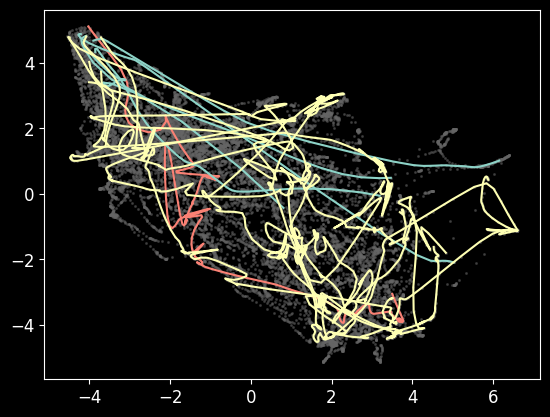

In [239]:
for u in umaps_by_fish:
    plt.scatter(u[:,0], u[:,1], marker='.', s=6, alpha=0.4, c='0.4')

plt.plot(umaps_by_fish[primary_selected_id][:,0], umaps_by_fish[primary_selected_id][:,1], c='C3')

short_thresh = 90
short_lived_fish = [unique_names[i_fish] for i_fish in range(len(unique_names)) if ages_by_fish[i_fish][-1] <= short_thresh]
for name in short_lived_fish:
    selected_id = int(onp.nonzero(unique_names==name)[0])
    plt.plot(umaps_by_fish[selected_id][:,0], umaps_by_fish[selected_id][:,1], c='C0')

long_thresh = 320
long_lived_fish = [unique_names[i_fish] for i_fish in range(len(unique_names)) if ages_by_fish[i_fish][-1] >= long_thresh]
for name in long_lived_fish:
    selected_id = int(onp.nonzero(unique_names==name)[0])
    plt.plot(umaps_by_fish[selected_id][:,0], umaps_by_fish[selected_id][:,1], c='C1')


## Animation fns

In [258]:
start_marker = 'o'
end_marker = 's'

# TODO Remove the iterating over multiple points -- it's a bit of a red herring
# and complicates the above code. I just end up plotting it in a single go because
# its easier while presenting to talk through it rather than press through it
def setup_lifespan_anim(ax, factors_by_fish, ages_by_fish,
                        static_ids=[], selected_ids=[], selected_starts=[],
                        xlim=(), ylim=(), cmap=LIFESPAN_CMAP):
    """Setup figure and axes to plot trajectory of 2D age factors.

    Parameters
    ----------
    factors_by_fish:  list, len (n_fish), of age factors
    ages_by_fish:     list, len (n_fish), of corresponding ages
    static_ids:       list, len (n_static), of fish idxs to full plot
    selected_ids:     list, len (n_selected), of fish idxs to plot, up to `selected_starts`
    selected_starts:  list, len (n_selected), of sample idxs to plots up to
        If empty list, then trajectories fo selected_ids plotted from start
    cmap:             ScalarMappable, maps lifespan to trajectory color
    """

    def _plot_factors(f, c, i_start=None):
        marker_size = 50
        alpha = 0.6

        # Plot trajectory up to i_start. If i_start is None, then plot whole trajectory
        i_start = len(f) if i_start is None else i_start
        traj = ax.plot(f[:i_start,0], f[:i_start,1], color=c, marker='.', alpha=alpha)

        # Plot start/end points
        start_pt = ax.scatter(f[0,0], f[0,1], marker=start_marker, s=marker_size,
                              color=c, ec='white', zorder=4)
        end_pt = ax.scatter(f[-1,0], f[-1,1], marker=end_marker, s=marker_size,
                            color=c, ec='white', zorder=4, alpha=0)
        return traj, start_pt, end_pt

    # ---------------------------------------------------------------------
    # Plot full trajectories of those indicated in `static_ids`
    # ---------------------------------------------------------------------
    for id in static_ids:
        _, _, end_pt = _plot_factors(factors_by_fish[id], cmap(ages_by_fish[id][-1]))
        end_pt.set_alpha(1)
    
    # ---------------------------------------------------------------------
    # Plot selected trajectorys up to the indicated (animation) start point
    # ---------------------------------------------------------------------
    # If selected starts are not indicated, then assume starting from 0
    if len(selected_starts) == 0:
        selected_starts = [0,] * len(selected_ids)

    trajs, end_pts = [], []
    for id, i_start in zip(selected_ids, selected_starts):
        # Plot trajectory, up to t. Hide end point (since we haven't reached it)
        traj, _, end_pt = \
            _plot_factors(factors_by_fish[id], cmap(ages_by_fish[id][-1]), i_start)
        end_pt.set_alpha(0)
        
        trajs.append(traj[0])
        end_pts.append(end_pt)
 
    # ---------------------------------------------------------------------
    # Make pretty
    # ---------------------------------------------------------------------
    # Set labels
    ax.set_xlabel('aging factor umap 0')
    ax.set_ylabel('aging factor umap 1')
    
    # Set limits
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_aspect('equal')

    # Do not show tick labels
    ax.tick_params(labelleft=False, labelbottom=False)

    # Hide spines, offset
    sns.despine(ax=ax, offset=10, trim=False)

    return trajs, end_pts

def make_anim_fn(factors, ages, trajs, end_pts,):

    def update_fn(i):
        """Animation function update. We know there's only one trajectory here."""
        mult_trajs = (len(trajs) > 1)
        for i_fish, (traj, end_pt) in enumerate(zip(trajs, end_pts)):
            factor, age_vec = factors[i_fish], ages[i_fish]

            # If finished plotting, just return
            if i >= len(factor):
                end_pt.set_alpha(1)
                continue;
            else:
                end_pt.set_alpha(0)
            
            # Display current chronological age, only if we are showing 1 trajectory (aka primary)
            if not mult_trajs:
                ax.set_title(f'age: {age_vec[i]} days', y=0.95, x=0.99, ha='right')
            
            # Plot trajectory up to t
            traj.set_data(factor[:i+1,0], factor[:i+1,1])
            
        return (*trajs, *end_pts)

    return update_fn

## Primary fish

In [256]:
# Discrete points at which to plot
i_start, i_end = [0, len(ages_by_fish[primary_selected_id])+5]
show_cbar = False               # DON'T show colorbar on first trajectory, need as much slide real estate as possible
show_background = False         # DON'T show background on first traj, it's confusing b/c haven't introduced it all yet

# -----------------------------------------------------------------------------
# Setup plots
fig, ax = plt.subplots(1,1, figsize=(9,9), dpi=120)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.87, top=0.9,)

if show_background:
    background_alpha = 0.2
    for f in umaps_by_fish:
        ax.scatter(f[:,0], f[:,1], s=6, marker='.', color='0.4', alpha=background_alpha,)

if show_cbar:
    cax = plt.axes((0.93, 0.25, 0.015, 0.5)) # (left, bottom, width, height)
    cbar = make_lifespan_colobar(cax=cax)
    cax.annotate('lifespan (days)', xy=(-0,0.5), xycoords='axes fraction',
                    xytext=(-0.5,0), textcoords='offset fontsize',
                rotation=90, ha='right', va='center', fontsize=12)
else:
    cax = None

trajs, end_pts = setup_lifespan_anim(ax, umaps_by_fish, ages_by_fish,
                                     selected_ids=[primary_selected_id],
                                     selected_starts=[i_start,],
                                     xlim=(-6, 8), ylim=(-5.5,5.5))

update_fn = make_anim_fn([umaps_by_fish[primary_selected_id]],
                         [ages_by_fish[primary_selected_id]],
                         trajs, end_pts,)

# -----------------------------------------------------------------------------
# Comment out below for "DRYRUN"
# anim = FuncAnimation(
#     fig, update_fn, frames=onp.arange(i_start, i_end), interval=100, blit=True)

# vid = anim.to_html5_video()
# html = display.HTML(vid)
# display.display(html)

# anim.save(f'./primary-{primary_fish_name}.mp4')

# plt.close()

## Overlay other fish

In [177]:
def get_fish_id_sorted_by_ls(cond):
    # Retrieve fish idx (as ordered in the list) and lifespan
    # array, shape (n_fish, [id, lifespan])
    info = onp.array(
        [(i_fish, ages_by_fish[i_fish][-1]) for i_fish in range(len(unique_names)) if cond(ages_by_fish[i_fish][-1])]
    )

    # Sort by lifespan
    i_sort = onp.argsort(info[:,1])

    # Return ids
    return info[i_sort, 0]

short_lived_ids = get_fish_id_sorted_by_ls(lambda ls: ls <= 90)
print('short:', len(short_lived_ids))
print(short_lived_ids)

mid_lived_ids = get_fish_id_sorted_by_ls(lambda ls: (ls >= 210) and (ls <= 290))
print('\nmid:', len(mid_lived_ids))
print(mid_lived_ids)

long_lived_ids = get_fish_id_sorted_by_ls(lambda ls: ls >= 320)
print('\nlong:', len(long_lived_ids))
print(long_lived_ids)


short: 5
[13  7  4 11 12]

mid: 39
[65 58 27 51 71 47 38 37 67 46  0 53 73 30 15 55 19 54  2 64 60 42 31 77
 72 43 69 63 80 62 59 78 26  9 81 10 44  6 34]

long: 7
[25 56 70 45 21 14  1]


### Other median-living fish

In [259]:
# Discrete points at which to plot
i_start, i_end = [0, len(ages_by_fish[primary_selected_id])+5]
show_cbar = True               # DON'T show colorbar on first trajectory, need as much slide real estate as possible
show_background = False         # DON'T show background on first traj, it's confusing b/c haven't introduced it all yet

selected_ids = mid_lived_ids[-2:]

# -----------------------------------------------------------------------------
# Setup plots
fig, ax = plt.subplots(1,1, figsize=(9,9), dpi=120)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.87, top=0.9,)

if show_background:
    background_alpha = 0.2
    for f in umaps_by_fish:
        ax.scatter(f[:,0], f[:,1], s=6, marker='.', color='0.4', alpha=background_alpha,)

if show_cbar:
    cax = plt.axes((0.93, 0.25, 0.015, 0.5)) # (left, bottom, width, height)
    cbar = make_lifespan_colobar(cax=cax)
    cax.annotate('lifespan (days)', xy=(-0,0.5), xycoords='axes fraction',
                    xytext=(-0.5,0), textcoords='offset fontsize',
                rotation=90, ha='right', va='center', fontsize=12)
else:
    cax = None

trajs, end_pts = setup_lifespan_anim(ax, umaps_by_fish, ages_by_fish,
                                     static_ids=[primary_selected_id],
                                     selected_ids=selected_ids,
                                     xlim=(-6, 8), ylim=(-5.5,5.5))

update_fn = make_anim_fn([umaps_by_fish[id] for id in selected_ids],
                         [ages_by_fish[id] for id in selected_ids],
                         trajs, end_pts,)

# -----------------------------------------------------------------------------
# Comment out below for "DRYRUN"
i_end = onp.max([ages_by_fish[id][-1] for id in selected_ids]) + 5

anim = FuncAnimation(
    fig, update_fn, frames=onp.arange(0, i_end), interval=100, blit=True)

vid = anim.to_html5_video()
html = display.HTML(vid)
display.display(html)

anim.save(f'./primary_mid.mp4')

plt.close()

### Long-lived fish

In [262]:
# Discrete points at which to plot
i_start, i_end = [0, len(ages_by_fish[primary_selected_id])+5]
show_cbar = True
show_background = False
background_alpha = 0.15

static_ids = [primary_selected_id, ]
selected_ids = [*mid_lived_ids[-2:], *long_lived_ids[[0,4]]]
# -----------------------------------------------------------------------------
# Setup plots
fig, ax = plt.subplots(1,1, figsize=(9,9), dpi=120)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.87, top=0.9,)

if show_background:    
    for f in umaps_by_fish:
        ax.scatter(f[:,0], f[:,1], s=6, marker='.', color='0.4', alpha=background_alpha,)

if show_cbar:
    cax = plt.axes((0.93, 0.25, 0.015, 0.5)) # (left, bottom, width, height)
    cbar = make_lifespan_colobar(cax=cax)
    cax.annotate('lifespan (days)', xy=(-0,0.5), xycoords='axes fraction',
                    xytext=(-0.5,0), textcoords='offset fontsize',
                rotation=90, ha='right', va='center', fontsize=12)
else:
    cax = None

trajs, end_pts = setup_lifespan_anim(ax, umaps_by_fish, ages_by_fish,
                                     static_ids=static_ids,
                                     selected_ids=selected_ids,
                                     xlim=(-6, 8), ylim=(-5.5,5.5))

update_fn = make_anim_fn([umaps_by_fish[id] for id in selected_ids],
                         [ages_by_fish[id] for id in selected_ids],
                         trajs, end_pts,)

# -----------------------------------------------------------------------------
# Comment out below for "DRYRUN"
i_end = onp.max([ages_by_fish[id][-1] for id in selected_ids]) + 5

anim = FuncAnimation(
    fig, update_fn, frames=onp.arange(0, i_end), interval=100, blit=True)

vid = anim.to_html5_video()
html = display.HTML(vid)
display.display(html)

anim.save(f'./primary_mid_long.mp4')

plt.close()

### Short-lived fish

In [337]:
# Discrete points at which to plot
i_start, i_end = [0, len(ages_by_fish[primary_selected_id])+5]
show_cbar = True
show_background = True
background_alpha = 0.0

# short_lived[[0,1,3]] appear to die mid-life
# short_lived[[2,4]] appear to die "sickly" (geriatric)
static_ids = [primary_selected_id, *mid_lived_ids[-2:], *long_lived_ids[[0,4]]]
selected_ids = short_lived_ids
# -----------------------------------------------------------------------------
# Setup plots
fig, ax = plt.subplots(1,1, figsize=(9,9), dpi=120)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.87, top=0.9,)

if show_background:
    for f in umaps_by_fish:
        ax.scatter(f[:,0], f[:,1], s=6, marker='.', color='0.4', alpha=background_alpha,)

if show_cbar:
    cax = plt.axes((0.93, 0.25, 0.015, 0.5)) # (left, bottom, width, height)
    cbar = make_lifespan_colobar(cax=cax)
    cax.annotate('lifespan (days)', xy=(-0,0.5), xycoords='axes fraction',
                    xytext=(-0.5,0), textcoords='offset fontsize',
                rotation=90, ha='right', va='center', fontsize=12)
else:
    cax = None

trajs, end_pts = setup_lifespan_anim(ax, umaps_by_fish, ages_by_fish,
                                     static_ids=static_ids,
                                     selected_ids=selected_ids,
                                     xlim=(-6, 8), ylim=(-5.5,5.5),)

update_fn = make_anim_fn([umaps_by_fish[id] for id in selected_ids],
                         [ages_by_fish[id] for id in selected_ids],
                         trajs, end_pts,)

# -----------------------------------------------------------------------------
# Comment out below for "DRYRUN"
# i_end = onp.max([ages_by_fish[id][-1] for id in selected_ids]) + 5

# anim = FuncAnimation(
#     fig, update_fn, frames=onp.arange(0, i_end), interval=100, blit=True)

# vid = anim.to_html5_video()
# html = display.HTML(vid)
# display.display(html)

# anim.save(f'./primary_mid_long_short.mp4')

# plt.close()

### Plot all trajectories now

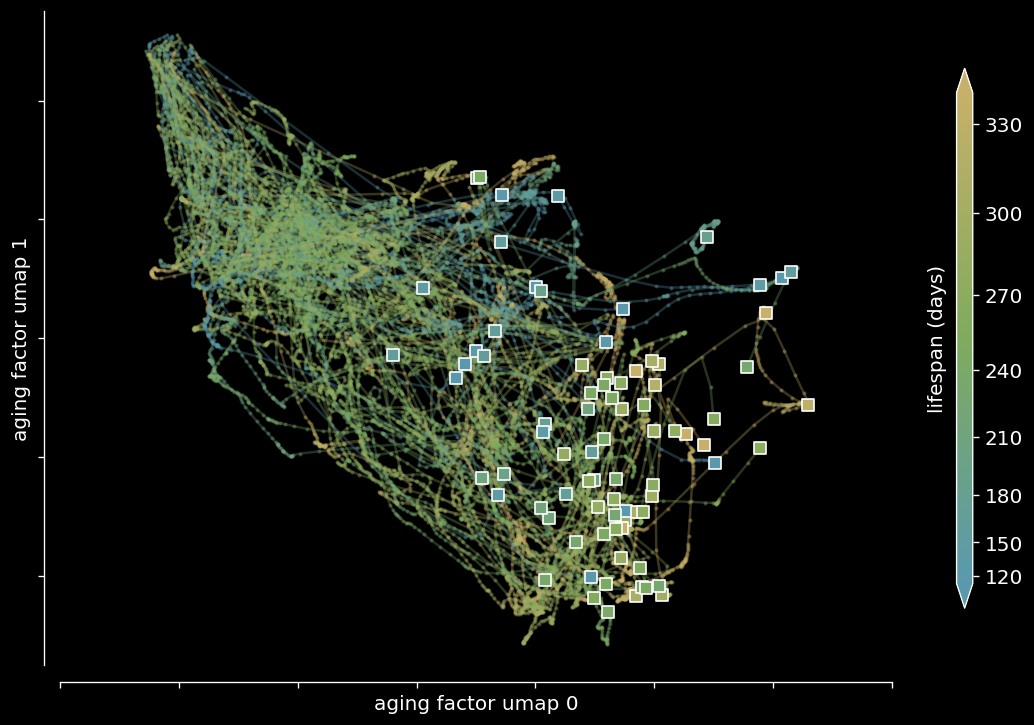

In [344]:
# Discrete points at which to plot
i_start, i_end = [0, len(ages_by_fish[primary_selected_id])+5]
show_cbar = True
show_background = True
background_alpha = 0.8

# -----------------------------------------------------------------------------
# Setup plots
fig, ax = plt.subplots(1,1, figsize=(9,9), dpi=120)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.87, top=0.9,)

for f, a in zip(umaps_by_fish, ages_by_fish):
    ls_color = LIFESPAN_CMAP(a[-1])
    # ax.scatter(f[:,0], f[:,1], s=6, marker='.', color=ls_color, alpha=0.3,)
    ax.plot(f[:,0], f[:,1], lw=1.5, ms=3, marker='.', color=ls_color, alpha=0.3,)
    ax.scatter(f[-1,0], f[-1,1], s=50, marker='s', color=ls_color, ec='white', alpha=1.0, zorder=100)

# Set labels
ax.set_xlabel('aging factor umap 0')
ax.set_ylabel('aging factor umap 1')

# Set limits
xlim=(-6, 8)
ylim=(-5.5,5.5)
ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.set_aspect('equal')

# Do not show tick labels
ax.tick_params(labelleft=False, labelbottom=False)

# Hide spines, offset
sns.despine(ax=ax, offset=10, trim=False)

if show_cbar:
    cax = plt.axes((0.93, 0.25, 0.015, 0.5)) # (left, bottom, width, height)
    cbar = make_lifespan_colobar(cax=cax)
    
    cax.annotate('lifespan (days)', xy=(-0,0.5), xycoords='axes fraction',
                 xytext=(-0.5,0), textcoords='offset fontsize',
                rotation=90, ha='right', va='center', fontsize=12)
else:
    cax = None


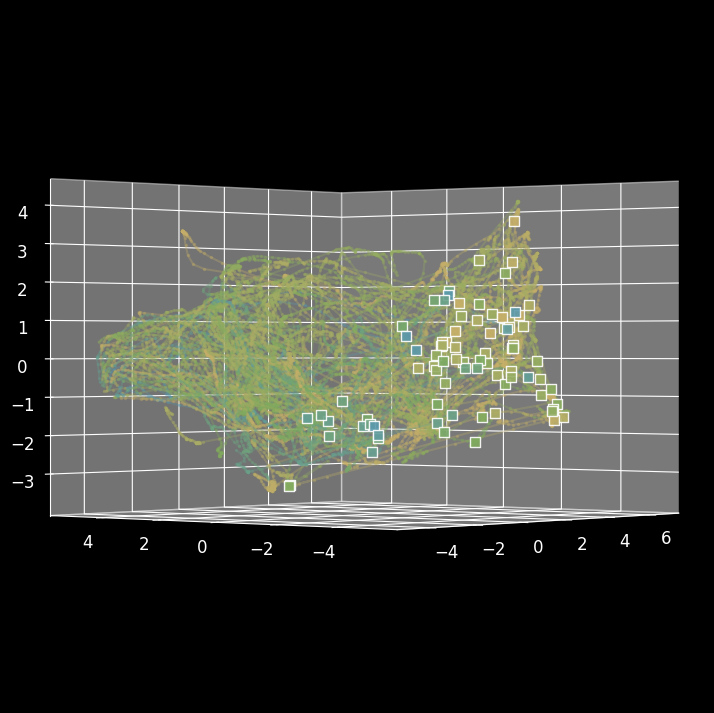

In [326]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1, projection='3d')

for f, a in zip(umaps_by_fish, ages_by_fish):
    ls_color = LIFESPAN_CMAP(a[-1])
    # ax.scatter(f[:,0], f[:,1], s=6, marker='.', color=ls_color, alpha=0.3,)
    ax.plot(f[:,0], f[:,1],f[:,2], lw=1.5, ms=3, marker='.', color=ls_color, alpha=0.3,)
    ax.scatter(f[-1,0], f[-1,1], f[-1,2], s=50, marker='s', color=ls_color, ec='white', alpha=0.9, zorder=100)
sns.despine()
ax.view_init(elev=0, azim=220)

In [ ]:

cosyne_names = ['fish7_146_cohort3', 'fish6_146_cohort4', 'fish4_137_cohort5',
         'fish11_137_cohort7', 'fish1_146_cohort3', 'fish3_146_cohort3',
         'fish0_137_cohort3', 'fish7_137_cohort4', 'fish5_146_cohort4',
         'fish9_146_cohort5', 'fish11_146_cohort4', 'fish4_146_cohort3',
         'fish2_146_cohort7', 'fish1_137_cohort3', 'fish10_137_cohort5',
         'fish3_137_cohort3', 'fish9_137_cohort5', 'fish8_137_cohort4',
         'fish8_146_cohort3', 'fish5_137_cohort3', 'fish0_146_cohort5',
         'fish6_137_cohort3', 'fish11_137_cohort4',]

one_at_a_time = [9, 14, 21,
                 2, 8, 17,] # default, long
mult_at_a_time = [(1, 7, 16), (5, 6, 22, 4, 21)] # short, rest

# for i in one_at_a_time:
for i in mult_at_a_time[0]:
    print(i, '\t', cosyne_names[i])


# Supplementary slides

## Lifespan distribution

In [44]:
lifespans = [a[-1] for a in ages_by_fish]

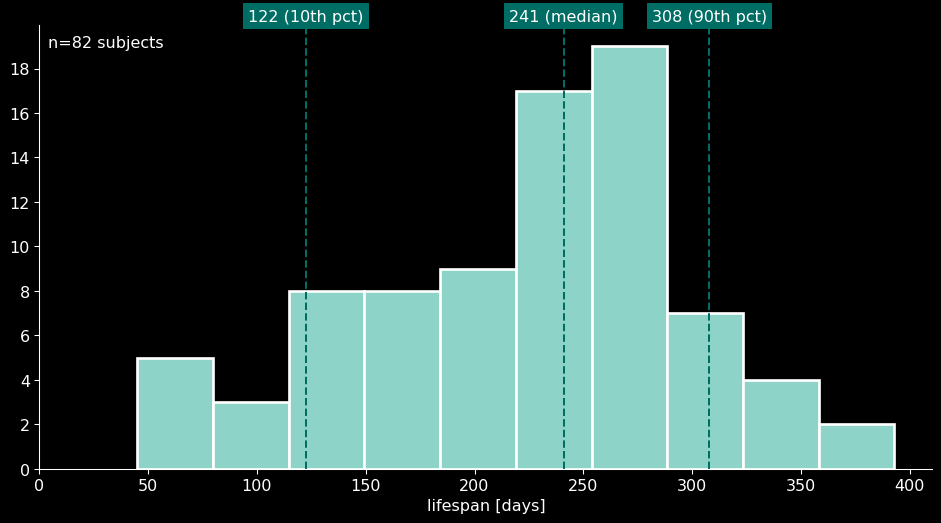

In [74]:
quantiles = [0.5, 0.1, 0.90]
qcolor = '#006d65'      # dark cyan
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=96)

ax.hist(ls, ec='white', lw=2)

for qnt in quantiles:
    vqnt = onp.quantile(lifespans, qnt)
    ax.axvline(vqnt, color=qcolor, ls='--')

    # Label
    if qnt == 0.5:
        qnt_label = f'{vqnt:.0f} (median)'
    else:
        qnt_label = f'{vqnt:.0f} ({qnt*100:.0f}th pct)'
    
    # x-axis is in data units, y-axis is in axes fraction units
    ax.text(vqnt, 1.01, qnt_label, transform=ax.get_xaxis_transform(),
            ha='center',
            bbox=dict(facecolor=qcolor, edgecolor='none'))

ax.set_xlim(left=0)
ax.set_xlabel('lifespan [days]')

# Force y-axis to display integer counts
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

# Display number of subjects
ax.text(0.01, 0.95, f'n={len(lifespans)} subjects', transform=ax.transAxes)
sns.despine()

## Factor log-like explained

In [9]:
params = run_params[primary_run_id]

ref_ll = params['avg_baseline_test_ll']
lofo_lls = {'aging factors': params['avg_lofo_test_ll_1'],
            'circadian bases': params['avg_lofo_test_ll_2'],
            'behavioral topics': params['avg_lofo_test_ll_3'],
            }

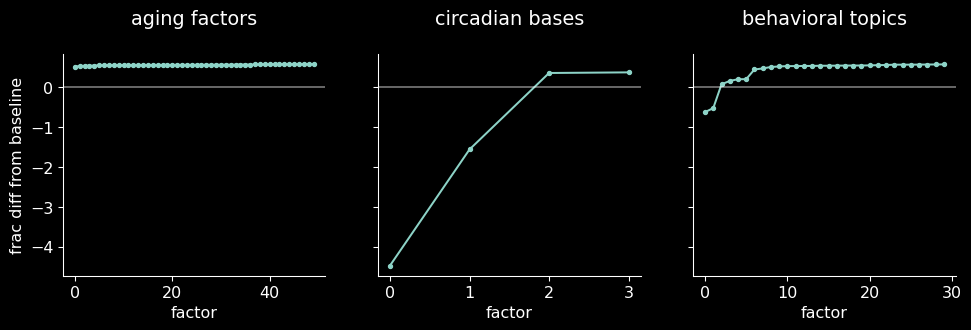

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True,
                        figsize=(12,3), gridspec_kw={'hspace': 0.3}, dpi=96)

# Facors and lls should already be sorted
for i, (ll_name, ll_val) in enumerate(lofo_lls.items()):
    frac_diff = (ref_ll - ll_val) / ref_ll 

    ax = axs[i]
    ax.plot(frac_diff, marker='.')
    
    ax.set_xlabel('factor')
    ax.set_title(ll_name, y=1.1)

    ax.axhline(0, alpha=0.4,)

axs[0].set_ylabel('frac diff from baseline')
sns.despine()

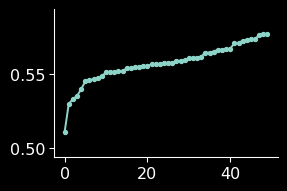

In [40]:
# Plot aging factors inset
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(3,2), dpi=96)

# Facors and lls should already be sorted
ll_name, ll_val = 'aging factors', lofo_lls['aging factors']
frac_diff = (ref_ll - ll_val) / ref_ll 

ax.plot(frac_diff, marker='.')
target_ylim_range = 0.1
ylims = frac_diff.min(), frac_diff.max()
if ylims[1] - ylims[0] < target_ylim_range:
    ymid = 0.5 * (ylims[1] + ylims[0])
    ylims = ymid - 0.5*target_ylim_range, ymid + 0.5*target_ylim_range

ax.set_ylim(*ylims)

# for ii, ylabel in enumerate(['test ll', 'baseline ll', 'saturated ll']):
#     axs[ii,0].set_ylabel(ylabel, ha='right', rotation=0)
sns.despine()

# Extra

## Reconstituting "topic weights"

a la original cosyne talk

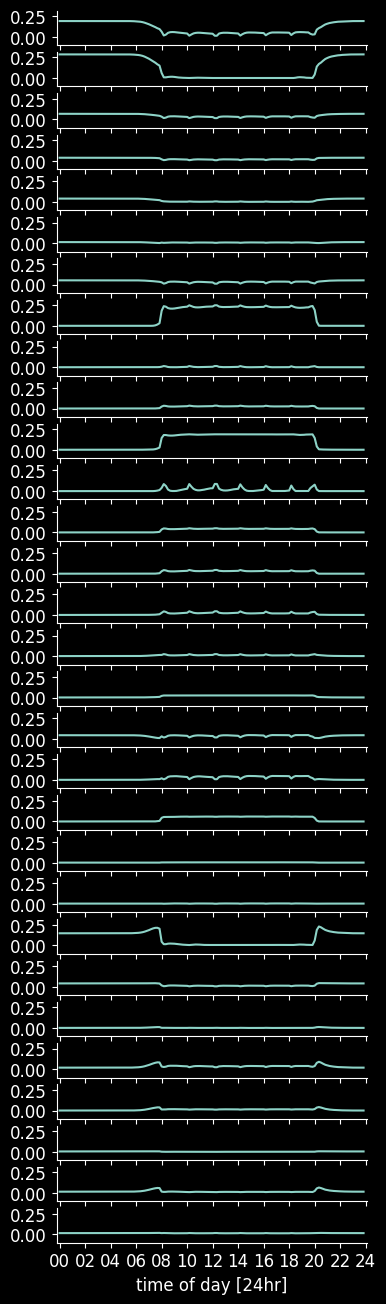

In [ ]:
F1_by_fish = split_array_by_fish(F1, ages_by_fish)
F1_selected = F1_by_fish[selected_id]
i_day = int(onp.nonzero(ages_by_fish[selected_id] == 105)[0])

# Compute topic weights for a single day
topic_weights = onp.einsum('abc,a,db->dc', G, F1_selected[i_day], F2)
D, K3 = topic_weights.shape

fig, axs = plt.subplots(nrows=K3, ncols=1, sharex=True, sharey=True, figsize=(4,16))
draw_circadian_bases(topic_weights, axs=axs);

In [ ]:
def get_cumulative_topic_usage(theta_d, sigma=None, reverse=True):
    """Calculate cumulative topic usage for each bin such that theta_d[:,-1] = 1."""
    n_bins = len(theta_d)
    
    if (sigma is not None) and sigma > 0:
        theta_d = gaussian_filter1d(theta_d, sigma, axis=0)
    
    if reverse:
        theta_cum = onp.cumsum(theta_d[:, ::-1], axis=-1)
    else:
        theta_cum = onp.cumsum(theta_d[:, ::-1], axis=-1)

    theta_cum = onp.concatenate([onp.zeros((n_bins,1)),
                                 theta_cum[:, :-1],
                                 onp.ones((n_bins,1))], axis=-1)

    return theta_cum

def plot_cumulative_topic_usage_d(ax, theta_cumulative, tod_tick_freq='2H', topic_names=[], cmap=None):
    """Plot topic usage for a given day via a "mountain" plot. 
    
    This visualization conveys that each bin is a proportion of topic expressions.

    """
    n_bins = theta_cumulative.shape[0]
    n_topics = theta_cumulative.shape[-1] - 1

    if cmap==None:
        cmap = sns.husl_palette(n_topics, h=.5, s=0.5)
    if len(topic_names) == 0:
        topic_names = [k for k in range(n_topics)]
    
    # Plot each topic's cumulative contribution to topic usage
    for k in range(n_topics):
        ax.fill_between(onp.arange(n_bins),
                        theta_cumulative[:,k], theta_cumulative[:,k+1],
                        color=cmap[k], edgecolor='white', label=topic_names[k])

    # Set time of day labels (x-axis)
    ax.set_xlabel('time of day')
    # set_tod_ticks(ax, tod_tick_freq, n_bins, show_first=True, offset_ticks=False)
    ax.set_xlim(-0.01, n_bins+0.01)

    # Set topic weight labels (y-axis)
    ax.set_ylabel('topic usage')
    ax.set_ylim(-0.05, 1.05)
    
    sns.despine(ax=ax)
    
    return

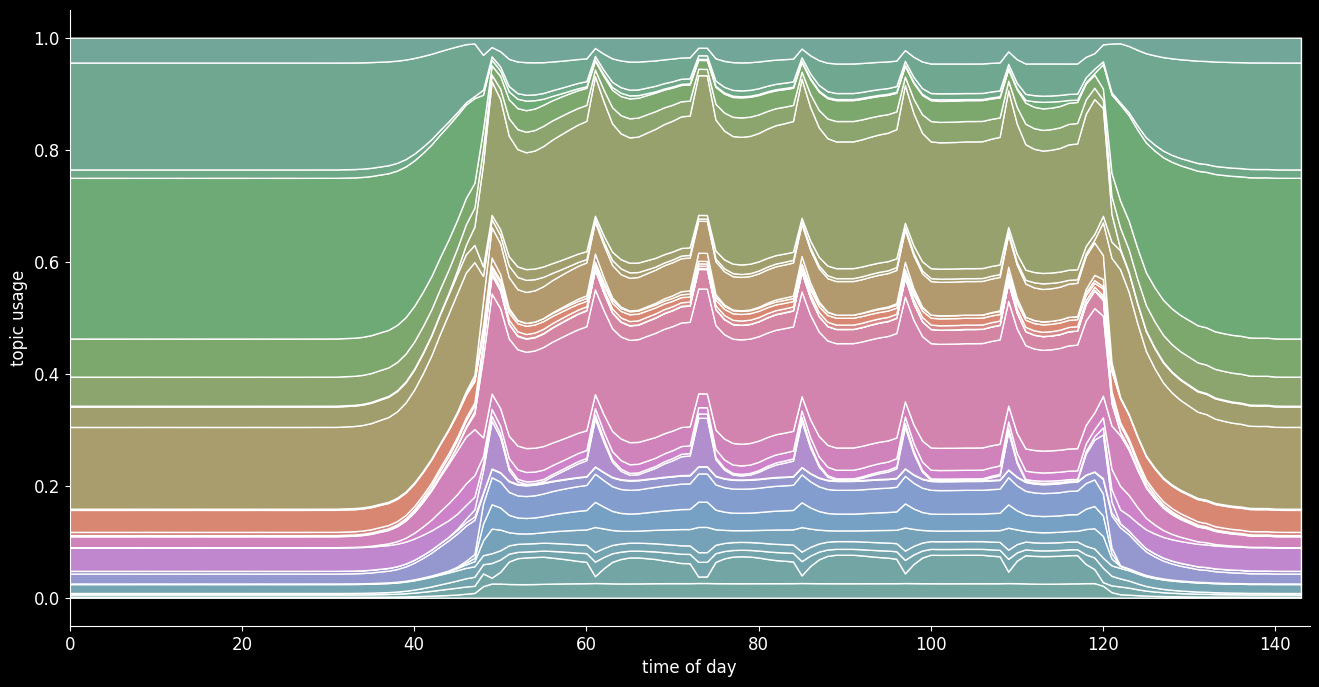

In [ ]:
# note that in cosyne talk, we had to smooth it to get okay looking topic weights.
# low rank / dim reduction naturally smoothes it out
cum_topic_usage = get_cumulative_topic_usage(topic_weights)
fig, ax = plt.subplots(1,1, figsize=(16,8))
plot_cumulative_topic_usage_d(ax, cum_topic_usage)